In [11]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
from datasets import load_from_disk
from tqdm import tqdm

In [20]:
def calculate_bi_score(model, input_ids, attention_mask):
    # Get all hidden states
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states

    bi_scores = []
    for i in range(len(hidden_states) - 1):
        x_i = hidden_states[i]
        x_i_plus_1 = hidden_states[i + 1]
        
        # Calculate cosine similarity
        similarity = nn.functional.cosine_similarity(x_i.unsqueeze(2), x_i_plus_1.unsqueeze(1), dim=-1)
        
        # Calculate BI score
        bi_score = 1 - similarity.mean().item()
        bi_scores.append(bi_score)
    
    return bi_scores

In [3]:
# Load pre-trained model and tokenizer
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
def convert_to_chat_input(question):
    messages = [
        {"role": "system", "content": "You are an AI assistant that excels in solving math problems."},
        {"role": "user", "content": question},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [5]:
ds = load_from_disk("/workspace/data/llama_large_mix_dataset_v1_1536")

In [23]:
ds = ds.shuffle(42)

In [24]:
bi_scores = []

for i in tqdm(range(1000)):
	text = ds[i]['input_text']
	inputs = tokenizer(convert_to_chat_input(text), return_tensors="pt")
	bi_scores.append(calculate_bi_score(model, inputs["input_ids"].cuda(), inputs["attention_mask"].cuda()))

100%|██████████| 1000/1000 [05:04<00:00,  3.29it/s]


In [30]:
scores = list(enumerate(list(torch.tensor(bi_scores).mean(0).numpy())))

In [35]:
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=False)

In [42]:
budget = 0.2
top_k = int(len(sorted_scores) * budget); top_k
selected_layers = set()
for i in range(top_k):
    # don't pick adjacent layers
	if	i-1 in selected_layers or i+1 in selected_layers:
		print(f"Skipping layer {sorted_scores[i][0]}")
		continue
	selected_layers.add(sorted_scores[i][0])

In [43]:
selected_layers

{18, 19, 20, 26, 27, 28}

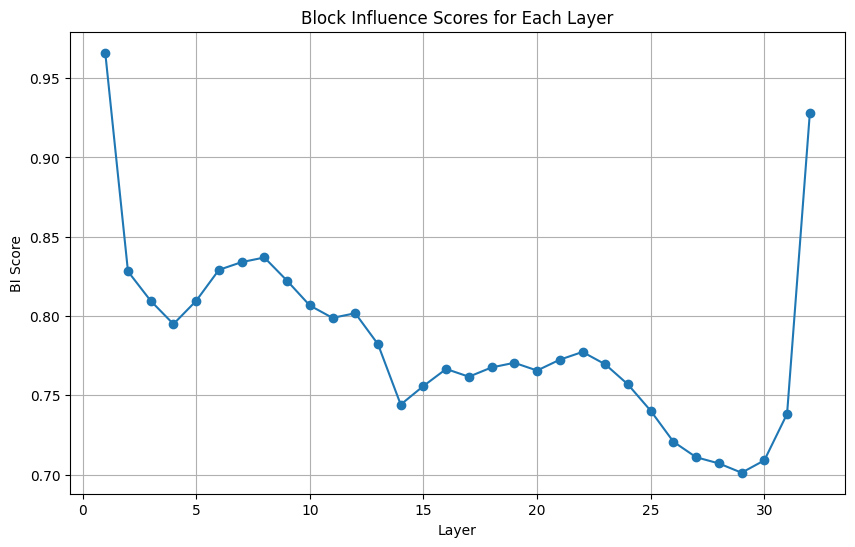

In [8]:
# Prepare input
text = """Here is python code to compute the BI score.

```python
def calculate_bi_score(model, input_ids, attention_mask):
    # Get all hidden states
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states

    bi_scores = []
    for i in range(len(hidden_states) - 1):
        x_i = hidden_states[i]
        x_i_plus_1 = hidden_states[i + 1]
        
        # Calculate cosine similarity
        similarity = nn.functional.cosine_similarity(x_i.unsqueeze(2), x_i_plus_1.unsqueeze(1), dim=-1)
        
        # Calculate BI score
        bi_score = 1 - similarity.mean().item()
        bi_scores.append(bi_score)
    
    return bi_scores
```
"""
inputs = tokenizer(convert_to_chat_input(text), return_tensors="pt")


# Calculate BI scores
bi_scores = calculate_bi_score(model, inputs["input_ids"].cuda(), inputs["attention_mask"].cuda())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(bi_scores) + 1), bi_scores, marker='o')
plt.title("Block Influence Scores for Each Layer")
plt.xlabel("Layer")
plt.ylabel("BI Score")
plt.grid(True)
plt.show()

# # Print results
# for i, score in enumerate(bi_scores, 1):
# 	print(f"Layer {i}: BI Score = {score:.4f}")

In [9]:
model.model.layers

ModuleList(
  (0-31): 32 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  )
)